In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hexg = gpd.read_file("../hex/hex_200_wdata.shp")
hexg = hexg.to_crs(epsg=32617).reset_index(drop=True) 
blcks = gpd.read_file("../blocks/blocks_pop_fixedgeom.geojson")
blcks = blcks.to_crs(epsg=32617).reset_index(drop=True) 

In [3]:
union = gpd.overlay(blcks, hexg, how='union')

<ipython-input-3-e9491fe3cbe1>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 1518 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(blcks, hexg, how='union')


In [4]:
union["area"] = union['geometry'].area
union["A_20_area"] = union["area"] * union["A_20_avg"]
union["A_21_area"] = union["area"] * union["A_21_avg"]

In [5]:
# Define a lambda function to compute the weighted mean:

dbs = union.groupby(["DBUID", "dbpop", "dauid"]).agg(A_21=("A_21_area", "sum"), A_20=("A_20_area", "sum"), area=("area", "sum"))
dbs["A_21"] = dbs["A_21"] / dbs["area"]
dbs["A_20"] = dbs["A_20"] / dbs["area"]
dbs["A_21"] = dbs["A_21"] - 1 
dbs["A_20"] = dbs["A_20"] - 1 
dbs.reset_index(inplace=True)
dbs["A_20_pop"] = dbs["dbpop"] * dbs["A_20"]
dbs["A_21_pop"] = dbs["dbpop"] * dbs["A_21"]
dbs["dauid"] = dbs["dauid"].astype(int)

In [6]:
da = dbs.groupby(["dauid"]).agg(A_21=("A_21_pop", "sum"), A_20=("A_20_pop", "sum"), pop=("dbpop", "sum"))
da["A_21"] = da["A_21"] / da["pop"]
da["A_20"] = da["A_20"] / da["pop"]
da.reset_index(inplace=True)
da["dauid"] = da["dauid"].astype(int)

Load census data

In [14]:
dfc = pd.read_csv("../blocks/da_census.csv")
dfc = dfc.fillna(0)


In [43]:
df = dbs.merge(dfc, how="inner", left_on="dauid", right_on="dauid")

In [44]:
df = df.fillna(0)
df["lico"] = df["lico"] * df["dbpop"] / df["pop"]
df["lim"] = df["lim"] * df["dbpop"] / df["pop"]
df["immig"] = (df["immig_1"] + df["immig_2"]) * df["dbpop"] / df["pop"] # recent immig + non PR
df["vismin"] = df["vismin"] * df["dbpop"] / df["pop"]
df = df.fillna(0)

In [45]:
dftc = pd.read_csv("../blocks/ct_tts_nocar.csv")
dfctdalink = pd.read_csv("../blocks/da_ct_2016_link.csv")
dftc = dftc.merge(dfctdalink, how="left", left_on="ctuid", right_on="ctuid")
dftc = dftc[["dauid","no_car_rate"]]
df = df.merge(dftc, how="inner", left_on="dauid", right_on="dauid")
df["no_car_rate"] = df["no_car_rate"].astype(float)
df["no_car_rate"] = df["no_car_rate"] * df["dbpop"]

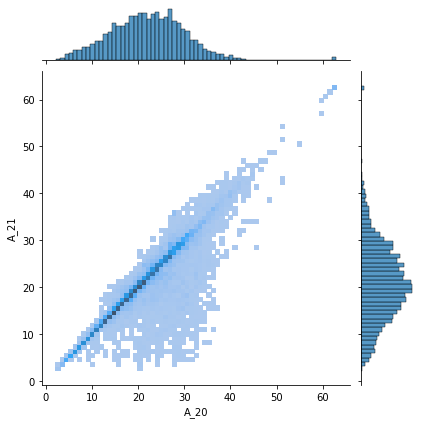

In [46]:
sns.jointplot(x="A_20", y="A_21", data=df, kind="hist")

In [47]:
out = []

j = 0
while j <= 65:
    pop_2020 = 0
    pop_2021 = 0
    lim_2020 = 0
    lim_2021 = 0
    lico_2020 = 0
    lico_2021 = 0
    vismin_2020 = 0
    vismin_2021 = 0
    immig_2020 = 0
    immig_2021 = 0
    nocar_2020 = 0
    nocar_2021 = 0
    for i, row in df.iterrows():
        if row["A_20"] <= j:
            pop_2020 = pop_2020 + row["dbpop"]
            lim_2020 = lim_2020 + row["lim"]
            lico_2020 = lico_2020 + row["lico"]
            immig_2020 = immig_2020 + row["immig"]
            vismin_2020 = vismin_2020 + row["vismin"]
            nocar_2020 = nocar_2020 + row["no_car_rate"]
        if row["A_21"] <= j:
            pop_2021 = pop_2021 + row["dbpop"]
            lim_2021 = lim_2021 + row["lim"]
            lico_2021 = lico_2021 + row["lico"]
            immig_2021 = immig_2021 + row["immig"]
            vismin_2021 = vismin_2021 + row["vismin"]
            nocar_2021 = nocar_2021 + row["no_car_rate"]
    out.append([j,pop_2020,pop_2021,lim_2020,lim_2021,lico_2020,lico_2021,vismin_2020,vismin_2021,immig_2020,immig_2021,nocar_2020,nocar_2021])
    j += 1

out = pd.DataFrame(out, columns = ["j","pop_2020","pop_2021","lim_2020","lim_2021","lico_2020","lico_2021",
                                  "vismin_2020","vismin_2021","immig_2020","immig_2021","nocar_2020","nocar_2021"])

In [49]:
out["pop_2020_p"] = out["pop_2020"] / sum(df.dbpop)
out["pop_2021_p"] = out["pop_2021"] / sum(df.dbpop)
out["lim_2020_p"] = out["lim_2020"] / sum(df.lim)
out["lim_2021_p"] = out["lim_2021"] / sum(df.lim)
out["lico_2020_p"] = out["lico_2020"] / sum(df.lico)
out["lico_2021_p"] = out["lico_2021"] / sum(df.lico)
out["immig_2020_p"] = out["immig_2020"] / sum(df.immig)
out["immig_2021_p"] = out["immig_2021"] / sum(df.immig)
out["vismin_2020_p"] = out["vismin_2020"] / sum(df.vismin)
out["vismin_2021_p"] = out["vismin_2021"] / sum(df.vismin)
out["nocar_2020_p"] = out["nocar_2020"] / sum(df.no_car_rate)
out["nocar_2021_p"] = out["nocar_2021"] / sum(df.no_car_rate)

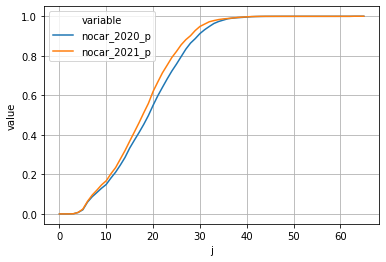

In [51]:
outp = pd.melt(out, id_vars=['j'], value_vars=['nocar_2020_p','nocar_2021_p'])
g = sns.lineplot(x="j", y="value", hue = "variable", data=outp)
plt.grid()  #just add this
plt.show()

In [52]:
out.to_csv("out_cdf.csv")

In [54]:
df[["DBUID","dbpop","A_21","A_20","area","lim","lico","vismin","pop","immig","no_car_rate"]].to_csv("out_db.csv")